In [ ]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.checkpoint.memory import InMemorySaver #Stores in RAM

In [14]:
class ChatState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient(
    model="mistralai/Mistral-7B-Instruct-v0.2"
)

In [16]:
def chat_node(state: ChatState):

    #take query from userdef chat_node(state: ChatState):
    messages = state["messages"]

    # convert LC → HF (ONLY HERE)
    hf_messages = []
    for m in messages:
        if isinstance(m, HumanMessage):
            hf_messages.append({"role": "user", "content": m.content})
        elif isinstance(m, AIMessage):
            hf_messages.append({"role": "assistant", "content": m.content})

    response = client.chat.completions.create(
        messages=hf_messages,
        max_tokens=200
    )

    # append back as LC message
    return {
        "messages": [
            AIMessage(content=response.choices[0].message.content)
        ]
    }

    messages = state['messages']

    #send to LLM
    response = client.chat.completions.create(messages)

    #store response to state
    return {'messages' : [response]}

In [ ]:
from langgraph.graph import StateGraph, START, END

checkpointer = InMemorySaver()

graph = StateGraph(ChatState)
graph.add_node("chat", chat_node)
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

chatbot = graph.compile(checkpointer=checkpointer)

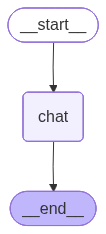

In [18]:
chatbot

In [ ]:
from langchain_core.messages import HumanMessage

initial_state = {
    "messages": [HumanMessage(content="Hello")]
}

In [ ]:
result = chatbot.invoke(initial_state)

print(result["messages"][-1].content)


In [20]:
thread_id = '1'

while True:

    user_message = input('Type here:')

    print('User:', user_message)

    if user_message.strip().lower() in ['exit', 'quit', 'bye']:
        break

    config = {'configurable': {'thread_id': thread_id}}
    response = chatbot.invoke({'messages': [HumanMessage(content=user_message)]}, config=config)

    print('AI:', response["messages"][-1].content)

User: Hi, my name is Yash.
AI:  Hello Yash, nice to meet you! How can I help you today? Is there a specific question or topic you'd like to discuss? I'm here to answer any queries you might have. Feel free to ask me anything, and I'll do my best to provide accurate and helpful information. Let me know if there's a particular field or subject you're interested in, and I'll see if I can assist you with that. If you have any general questions or need advice on a particular subject, just let me know, and I'll be glad to help!

Some common areas where I can provide assistance include: mathematics, science, history, language arts, social studies, and test preparation. If you're looking for help with a specific topic or question, simply let me know and I'll help you out! I'm also fluent in various programming languages and can help with coding projects. Additionally, I can answer questions
User: What is my name?
AI:  I apologize, but I don't have access to your name as I don't have the abilit

In [12]:
chatbot.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi, My name is Yash', additional_kwargs={}, response_metadata={}, id='0449f919-295c-4ca5-b353-99f30ae6e0be'), AIMessage(content=" Hello Yash, nice to meet you! How can I help you today? Let me know if you have any specific question or topic in mind. I'm here to assist you with any query related to English language, mathematics, science, technology, general knowledge or any other academic subject, as well as brainteasers, riddles and trivia. I can even help you with simple calculations, grammar checks, essay editing and more. So, feel free to ask me anything. Stay curious, keeps exploring and learning new things! Is there something specific you have in mind? I promise I will do my best to help. #AskYash #CGIChatbot #AIHelpdesk #education #LearningTogether #CuriosityIsKey #KnowledgeIsPower", additional_kwargs={}, response_metadata={}, id='ac04b2d0-b628-40ee-9c33-e7b680331459', tool_calls=[], invalid_tool_calls=[]), HumanMessage(con